In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
from IPython.display import display

In [2]:
# Useful for timing slow functions
def timer(func):
    def wrapper(*args, **kwargs):
        t0 = time.time()
        value = func(*args, **kwargs)
        print "Elapsed time: %.3f seconds" % (time.time() - t0)
        elapsed_time = time.time() - t0
        return value
    return wrapper

# Read in the data
- `df_reg_detailed`: Detailed game-by-game summaries for the regular season
- `df_tourney_detailed`: Detailed game-by-game summaries for the tournament
- `df_team_info`: Unique team identifiers
- `df_massey`: Team rankings (from a variety of ranking systems) back to 2003
- `df_seeds`: Seeding for tournaments back to 1985

In [3]:
fp_data = "../../2022/"
df_reg_detailed = pd.read_csv(fp_data + 'MDataFiles_Stage2/MRegularSeasonDetailedResults.csv')
df_tourney_detailed = pd.read_csv(fp_data + 'MDataFiles_Stage2/MNCAATourneyDetailedResults.csv')
df_team_info = pd.read_csv(fp_data + 'MDataFiles_Stage2/MTeams.csv')
df_massey = pd.read_csv(fp_data + '/MDataFiles_Stage2/MMasseyOrdinals.csv')
df_seeds = pd.read_csv(fp_data + 'MDataFiles_Stage2/MNCAATourneySeeds.csv')

In [4]:
def getTeamID(team_name):
    """
    Helper function to get a TeamID from its name
    
    :param team_name: Team name, e.g., "USC"
    :type team_name: str
    
    :return: Unique TeamID
    :rtype: int
    """
    return df_team_info[df_team_info['TeamName'] == team_name]['TeamID'].values[0]

def getTeamName(team_id):
    """
    Helper function to get a team name from its ID
    
    :param team_id: Unique TeamID for team, from df_team_info
    :type team_id: int
    
    :return: Team name
    :rtype: str
    """
    return df_team_info[df_team_info['TeamID'] == team_id]['TeamName'].values[0]

def getTeamSeason(team_id, season):
    """
    Get the stats for a team_id for a specific season.
    
    :param team_id: Unique TeamID for team, from df_team_info
    :type team_id: int
    
    :param season: Season to grab stats for
    :type season: int
    
    :return: Full season and season summary information
    :rtype: DataFrame, dict
    """
    df_season = df_reg_detailed[
        (df_reg_detailed['Season'] == season) & (
            (df_reg_detailed['WTeamID'] == team_id) | (df_reg_detailed['LTeamID'] == team_id)
        )
    ]
    # Grab the games the team won and the games the team lost
    df_win = df_season[df_season['WTeamID'] == team_id]
    df_lose = df_season[df_season['LTeamID'] == team_id]
    # Put everything in one DataFrame. Remove W and L suffixes, add _a for the opposing team
    df_win = df_win.rename(columns={
        'LTeamID':'TeamID_a', 'WScore':'Score', 'LScore':'Score_a','WLoc':'Loc',
        'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3', 'WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA',
        'WOR':'OR', 'WDR':'DR', 'WAst':'Ast', 'WTO':'TO', 'WStl':'Stl', 'WBlk':'Blk', 'WPF':'PF',
        'LFGM':'FGM_a', 'LFGA':'FGA_a', 'LFGM3':'FGM3_a', 'LFGA3':'FGA3_a', 'LFTM':'FTM_a', 'LFTA':'FTA_a',
        'LOR':'OR_a', 'LDR':'DR_a', 'LAst':'Ast_a', 'LTO':'TO_a', 'LStl':'Stl_a', 'LBlk':'Blk_a', 'LPF':'PF_a'
    }).drop(columns=['WTeamID'])
    df_lose = df_lose.rename(columns={
        'WTeamID':'TeamID_a', 'LScore':'Score', 'WScore':'Score_a','WLoc':'Loc',
        'WFGM':'FGM_a', 'WFGA':'FGA_a', 'WFGM3':'FGM3_a', 'WFGA3':'FGA3_a', 'WFTM':'FTM_a', 'WFTA':'FTA_a',
        'WOR':'OR_a', 'WDR':'DR_a', 'WAst':'Ast_a', 'WTO':'TO_a', 'WStl':'Stl_a', 'WBlk':'Blk_a', 'WPF':'PF_a',
        'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3', 'LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA',
        'LOR':'OR', 'LDR':'DR', 'LAst':'Ast', 'LTO':'TO', 'LStl':'Stl', 'LBlk':'Blk', 'LPF':'PF'
    }).drop(columns=['LTeamID'])
    
    if len(df_lose) != 0:
        df_lose['Loc'] = df_lose.apply(lambda row: 'L' if row['Loc']=='H' else 'H', axis=1)

    df_season = pd.concat([df_win, df_lose], sort=False)
    df_season['Win'] = df_season.apply(lambda row: 1 if row['Score'] > row['Score_a'] else 0, axis=1)

    # Compute summary values
    n_games = len(df_season)
    n_win = df_season['Win'].sum()
    win_percentage = float(n_win)/n_games
    
    points_scored = df_season['Score'].sum()
    points_allowed = df_season['Score_a'].sum()
    
    # Take average per game
    points_scored /= float(n_games)
    points_allowed /= float(n_games)

    # Get the team's ranking
    # Tourney start date
    tourney_start = df_tourney_detailed[df_tourney_detailed['Season'] == season]['DayNum'].min()
    # TODO: Choose ranking system(s) to use
    systems = [
        'BWE'
        '7OT', 'AP',  'BBT', 'BIH', 'BWE', 'COL', 'DCI', 'DII', 'DOK', 'DOL', 'DUN', 'EBP',
        'FAS', 'HAS', 'INC', 'JJK', 'JNG', 'KPK', 'KRA', 'LAW', 'LEF', 'LMC', 'LOG', 'MAS',
        'MOR', 'NET', 'NOL', 'PGH', 'PIR', 'POM', 'REW', 'RT',  'RTP', 'SAG', 'SEL', 'SFX',
        'SPR', 'TPR', 'TRK', 'TRP', 'USA', 'WIL', 'WLK', 'WMV', 'WOB',
    ]
    # First get the rankings for team for the last day of season outside of loop
    df_tmp = df_massey[
        (df_massey['Season']==season) &
        (df_massey['TeamID'] == team_id) &
        (df_massey['RankingDayNum'] < tourney_start)
    ]
    rank = {}
    for syst in systems:
        try:
            final_index = df_tmp[df_tmp['SystemName'] == syst]['RankingDayNum'].idxmax()
            rank[syst] = df_tmp.loc[final_index,:]['OrdinalRank']
        except:
            # If unranked, assign 100
            rank[syst] = 100

    # Play stats
    # Field goals
    fgm = df_season['FGM'].sum()
    fga = df_season['FGA'].sum()
    fgp = float(fgm)/float(fga)
    fga /= float(n_games)
    
    # 3 pointers
    fg3m = df_season['FGM3'].sum()
    fg3a = df_season['FGA3'].sum()
    fg3p = float(fg3m)/float(fg3a)
    fg3a /= float(n_games)

    # Free throws
    ftm = df_season['FTM'].sum()
    fta = df_season['FTA'].sum()
    ftp = float(ftm)/float(fta)
    fta /= float(n_games)

    # Rebounds, assists, turnovers, steals, blocks, personal fouls
    orm = df_season['OR'].sum()
    drm = df_season['DR'].sum()
    ast = df_season['Ast'].sum()
    tom = df_season['TO'].sum()
    stl = df_season['Stl'].sum()
    blk = df_season['Blk'].sum()
    pfm = df_season['PF'].sum()
    
    # Per game
    orm /= float(n_games)
    drm /= float(n_games)
    ast /= float(n_games)
    tom /= float(n_games)
    stl /= float(n_games)
    blk /= float(n_games)
    pfm /= float(n_games)

    # Tournament info
    try:
        seed = int(df_seeds[(df_seeds['Season'] == season) & (df_seeds['TeamID'] == team_id)]['Seed'].values[0][1:3])
    except:
        # If unranked, assign 100
        seed = 100
    
    team_summary = {
        "TeamID": team_id,
        "TeamName": getTeamName(team_id),
        "NGames": n_games,
        "Seed": seed,
        "WinPercentage": win_percentage,
        "PointsScoredPerGame": points_scored,
        "PointsAllowedPerGame": points_allowed,
        "FieldGoalPercentage": fgp,
        "FieldGoalAttemptsPerGame": fga,
        "ThreePointPercentage": fg3p,
        "ThreePointAttemptsPerGame": fg3a,
        "FreeThrowPercentage": ftp,
        "FreeThrowAttemptsPerGame": fta,
        "OffensiveReboundsPerGame": orm,
        "DefensiveReboundsPerGame": drm,
        "AssistsPerGame": ast,
        "TurnOversCommittedPerGame": tom,
        "StealsPerGame": stl,
        "BlocksPerGame": blk,
        "PersonalFoulsPerGame": pfm,
    }
    for syst in rank.keys():
        team_summary["Rank%s" % (syst)] = rank[syst]
    return df_season, team_summary

@timer
def getTeamSummaries(season):
    """
    Calls getTeamSeason for all teams for a given season
    
    :param season: Season to grab stats for
    :type season: int
    
    :return: Team season and team summary information
    :rtype: dict of DataFrames, DataFrame
    """
    print "Working on season %i" % season
    winning_team_ids = df_reg_detailed[(df_reg_detailed['Season'] == season)]['WTeamID'].unique()
    losing_team_ids = df_reg_detailed[(df_reg_detailed['Season'] == season)]['LTeamID'].unique()
    team_id_list = np.unique(np.concatenate([winning_team_ids,losing_team_ids]))
    team_seasons, team_summaries = {}, {}
    for team_id in team_id_list:
        team_seasons[team_id], team_summaries[team_id] = getTeamSeason(team_id, season)
    df_team_summaries = pd.DataFrame(team_summaries).T.reset_index(drop=True)
    return team_seasons, df_team_summaries

def getStrengthOfSchedule(team_id, season):
    """
    Computes the strength of schedule for a team for a given season. Strength of schedule is equal to the
    median of the BWE ranks of all opponents
    
    :param team_id: Unique ID for team, from df_team_info
    :type team_id: int
    
    :param season: Season to grab stats for
    :type season: int
    
    :return: int
    """
    opponents = team_seasons[season][team_id]['TeamID_a']
    return np.median([df_team_summaries[season][df_team_summaries[season]['TeamID'] == opp]['RankBWE'].values[0] for opp in opponents.values])

def getMadePlayoffs(team_id, season):
    """
    Checks if the team made the playoffs in a season
    
    :param team_id: Unique ID for team, from df_team_info
    :type team_id: int
    
    :param season: Season to grab stats for
    :type season: int
    
    :return: Bool 0 or 1
    :rtype: int
    """ 
    if df_team_summaries[season][df_team_summaries[season]['TeamID'] == team_id]['Seed'].values[0] != 100:
        return 1
    else:
        return 0

@timer
def createSeasonMatchupDF(season):
    """
    Creates the feature vectors for all matchups in a given season + tournament
    
    :param season: Season to create matchups for
    :type season: int
    
    :return: Regular season and tournament matchup information
    :rtype: DataFrame, DataFrame
    """
    print "Working on season %i" % (season)
    # First grab all of the column names
    df_tmp = df_team_summaries[season].set_index('TeamID')
    keys = ['Diff_' + col for col in df_tmp.columns.drop(['TeamName'])]

    # Add in the game-specific properties to the team-specific properties
    columns = ['Location', 'HighStakes','Winner'] + keys
    
    # Create empty DataFrame for the season and load in the regular season and tourney DataFrames
    df_matchups_reg = pd.DataFrame(columns=columns)
    df_matchups_tourney = pd.DataFrame(columns=columns)
    df_season = df_reg_detailed[df_reg_detailed['Season'] == season]
    df_tourney = df_tourney_detailed[df_tourney_detailed['Season'] == season]
    
    print "Regular season..."
    for index, row in df_season.iterrows():
        # Need to have both wins and losses, so randomly choose which team to put first
        choice = np.random.randint(2)
        
        w_team_summary = df_tmp.loc[row['WTeamID']]
        l_team_summary = df_tmp.loc[row['LTeamID']]
        
        # Home or away for the winning team
        loc_map = {'H':1., 'N':0., 'A':-1.}
        
        # Something to note if it's a 'high stakes' game like a tourney or rivalry game
        # TODO: Add in rivalry games
        high_stakes = 0.
        
        game_dict = {}
        if choice == 1:
            game_dict['Location'] = loc_map[row['WLoc']]
            game_dict['HighStakes'] = high_stakes
            game_dict['Winner'] = 1.
            game_dict['Diff_Score'] = row['WScore'] - row['LScore']
            game_dict['DayOfGame'] = row['DayNum']
            for col in w_team_summary.keys():
                if type(w_team_summary[col]) != str:
                    game_dict['Diff_'+col] = w_team_summary[col] - l_team_summary[col]
        else:
            game_dict['Location'] = -loc_map[row['WLoc']]
            game_dict['HighStakes'] = high_stakes
            game_dict['Winner'] = 0.
            game_dict['Diff_Score'] = row['LScore'] - row['WScore']
            game_dict['DayOfGame'] = row['DayNum']            
            for col in w_team_summary.keys():
                if type(w_team_summary[col]) != str:
                    game_dict['Diff_'+col] = l_team_summary[col] - w_team_summary[col]

        df_matchups_reg = df_matchups_reg.append(game_dict, ignore_index=True)

    print "Tournament..."
    for index, row in df_tourney.iterrows():
        # Need to have both wins and losses, so randomly choose which team to put first
        choice = np.random.randint(2)
        
        w_team_summary = df_tmp.loc[row['WTeamID']]
        l_team_summary = df_tmp.loc[row['LTeamID']]
        
        # Home or away for the winning team
        loc_map = {'H':1., 'N':0., 'A':-1.}
        
        # Something to note if it's a 'high stakes' game like a tourney or rivalry game
        # TODO: Add in rivalry games
        high_stakes = 1.
        
        game_dict = {}
        if choice == 1:
            game_dict['Location'] = loc_map[row['WLoc']]
            game_dict['HighStakes'] = high_stakes
            game_dict['Winner'] = 1.
            game_dict['Diff_Score'] = row['WScore'] - row['LScore']
            game_dict['DayOfGame'] = row['DayNum']
            for col in w_team_summary.keys():
                if type(w_team_summary[col]) != str:
                    game_dict['Diff_'+col] = w_team_summary[col] - l_team_summary[col]
        else:
            game_dict['Location'] = -loc_map[row['WLoc']]
            game_dict['HighStakes'] = high_stakes
            game_dict['Winner'] = 0.
            game_dict['Diff_Score'] = row['LScore'] - row['WScore']
            game_dict['DayOfGame'] = row['DayNum']            
            for col in w_team_summary.keys():
                if type(w_team_summary[col]) != str:
                    game_dict['Diff_'+col] = l_team_summary[col] - w_team_summary[col]
        df_matchups_tourney = df_matchups_tourney.append(game_dict, ignore_index=True)

    return df_matchups_reg, df_matchups_tourney

# Load in the data and compute the team summaries, matchups, etc.

In [5]:
# Team summaries
df_team_summaries, team_seasons = {}, {}
for season in [2015,2016,2017,2018,2019,2020,2021,2022]:
    team_seasons[season], df_team_summaries[season] = getTeamSummaries(season=season)

Working on season 2015
Elapsed time: 53.453 seconds
Working on season 2016
Elapsed time: 42.899 seconds
Working on season 2017
Elapsed time: 38.807 seconds
Working on season 2018
Elapsed time: 39.001 seconds
Working on season 2019
Elapsed time: 40.074 seconds
Working on season 2020
Elapsed time: 35.122 seconds
Working on season 2021
Elapsed time: 39.366 seconds
Working on season 2022
Elapsed time: 35.371 seconds


In [6]:
# Add in strength of schedule and madeplayoffs
for season in [2015,2016,2017,2018,2019,2020,2021,2022]:
    print "Working on season %i" % season
    df_team_summaries[season]['StrengthOfSchedule'] = df_team_summaries[season].apply(lambda row: getStrengthOfSchedule(row['TeamID'], season), axis=1)
    df_team_summaries[season]['MadePlayoffs'] = df_team_summaries[season].apply(lambda row: getMadePlayoffs(row['TeamID'], season), axis=1)

Working on season 2015
Working on season 2016
Working on season 2017
Working on season 2018
Working on season 2019
Working on season 2020
Working on season 2021
Working on season 2022


In [8]:
# Example: USC
display(df_team_summaries[2019][df_team_summaries[2019]['TeamID'] == getTeamID('USC')])
display(team_seasons[2019][getTeamID('USC')].head(10))

,AssistsPerGame,BlocksPerGame,DefensiveReboundsPerGame,FieldGoalAttemptsPerGame,FieldGoalPercentage,FreeThrowAttemptsPerGame,FreeThrowPercentage,NGames,OffensiveReboundsPerGame,PersonalFoulsPerGame,...,Seed,StealsPerGame,TeamID,TeamName,ThreePointAttemptsPerGame,ThreePointPercentage,TurnOversCommittedPerGame,WinPercentage,StrengthOfSchedule,MadePlayoffs
314,16.2424,3.54545,26.0909,61.7879,0.459539,17.0606,0.64476,33,9.81818,17.8788,...,100,6.12121,1425,USC,22.2727,0.382313,11.8788,0.484848,101.0,0


,Season,DayNum,Score,TeamID_a,Score_a,Loc,NumOT,FGM,FGA,FGM3,...,FTM_a,FTA_a,OR_a,DR_a,Ast_a,TO_a,Stl_a,Blk_a,PF_a,Win
82125,2019,1,83,1352,62,H,0,30,57,7,...,9,11,11,20,16,11,6,2,23,1
82410,2019,9,95,1391,59,H,0,36,64,7,...,7,11,16,22,12,11,7,2,18,1
82728,2019,15,99,1283,80,N,0,37,65,17,...,16,21,10,21,13,12,2,3,10,1
82966,2019,20,90,1167,75,H,0,29,52,10,...,11,22,14,24,14,14,6,0,27,1
83081,2019,23,75,1253,65,H,0,27,64,7,...,10,18,19,29,13,13,3,2,21,1
83869,2019,46,91,1381,49,H,0,36,67,7,...,7,17,8,23,9,24,5,5,18,1
84117,2019,55,73,1413,55,H,0,29,55,10,...,7,11,12,20,11,15,6,0,13,1
84245,2019,59,82,1143,73,H,0,31,58,5,...,9,13,9,23,14,9,4,5,20,1
84414,2019,62,77,1390,66,H,0,30,62,4,...,6,10,7,21,19,15,5,7,20,1
85020,2019,75,80,1417,67,H,0,30,64,12,...,4,12,16,28,13,20,8,4,15,1


In [9]:
# Create the matchups
df_matchups_reg, df_matchups_tourney = {}, {}
for season in [2015,2016,2017,2018,2019,2020,2021,2022]:
    df_matchups_reg[season], df_matchups_tourney[season] = createSeasonMatchupDF(season)

Working on season 2015
Regular season...
Tournament...
Elapsed time: 32.480 seconds
Working on season 2016
Regular season...
Tournament...
Elapsed time: 35.026 seconds
Working on season 2017
Regular season...
Tournament...
Elapsed time: 43.413 seconds
Working on season 2018
Regular season...
Tournament...
Elapsed time: 40.380 seconds
Working on season 2019
Regular season...
Tournament...
Elapsed time: 40.782 seconds
Working on season 2020
Regular season...
Tournament...
Elapsed time: 36.264 seconds
Working on season 2021
Regular season...
Tournament...
Elapsed time: 27.906 seconds
Working on season 2022
Regular season...
Tournament...
Elapsed time: 36.209 seconds


In [10]:
# Example: 2019 regular season
df_matchups_reg[2019].head(10)

,Location,HighStakes,Winner,Diff_AssistsPerGame,Diff_BlocksPerGame,Diff_DefensiveReboundsPerGame,Diff_FieldGoalAttemptsPerGame,Diff_FieldGoalPercentage,Diff_FreeThrowAttemptsPerGame,Diff_FreeThrowPercentage,...,Diff_Seed,Diff_StealsPerGame,Diff_ThreePointAttemptsPerGame,Diff_ThreePointPercentage,Diff_TurnOversCommittedPerGame,Diff_WinPercentage,Diff_StrengthOfSchedule,Diff_MadePlayoffs,DayOfGame,Diff_Score
0,-1.0,0.0,0.0,-0.796676,-2.118280,-5.811339,-3.364614,-0.004161,-3.394917,0.000822,...,0.0,1.974585,-3.816227,-0.012905,2.264907,-0.351906,230.0,0.0,1.0,-20.0
1,1.0,0.0,1.0,2.367944,-0.071573,0.844758,3.726815,0.001587,4.422379,-0.035018,...,-89.0,0.347782,4.185484,0.031158,-0.019153,0.235887,-79.0,1.0,1.0,8.0
2,1.0,0.0,1.0,3.193548,-0.161290,3.096774,7.580645,-0.022021,-2.354839,-0.004380,...,0.0,0.451613,4.612903,-0.045115,-0.741935,0.000000,-11.0,0.0,1.0,4.0
3,1.0,0.0,1.0,1.036765,0.889706,-1.308824,5.378676,-0.006828,-0.608456,0.034111,...,-95.0,3.606618,7.689338,0.010499,-1.352941,0.266544,-151.5,1.0,1.0,43.0
4,1.0,0.0,1.0,1.969828,1.293103,3.871767,1.417026,0.030034,1.540948,-0.031936,...,0.0,-0.030172,2.822198,-0.033545,1.690733,0.020474,-13.0,0.0,1.0,17.0
5,1.0,0.0,1.0,1.122581,0.322581,0.497849,-0.310753,0.007496,3.886022,-0.043673,...,0.0,0.362366,0.194624,-0.021070,-0.240860,0.184946,-119.5,0.0,1.0,20.0
6,1.0,0.0,0.0,0.927083,0.026515,1.600379,-3.602273,0.005090,4.262311,0.066718,...,-87.0,0.089015,6.026515,0.046449,-1.538826,0.259470,-53.5,1.0,1.0,-3.0
7,1.0,0.0,1.0,4.736364,1.190909,4.248485,5.057576,0.034229,-0.184848,-0.020142,...,-94.0,0.809091,7.078788,-0.015900,-0.572727,0.375758,-133.0,1.0,1.0,15.0
8,1.0,0.0,1.0,-0.815733,0.996767,-2.599138,-2.827586,0.006299,-1.584052,0.020635,...,0.0,1.656250,5.781250,-0.011541,-3.197198,0.304957,2.0,0.0,1.0,4.0
9,1.0,0.0,0.0,2.699353,-1.257543,-1.595905,-2.279095,0.040589,-1.299569,-0.038826,...,0.0,1.370690,5.835129,0.054076,-1.853448,0.220905,-22.0,0.0,1.0,-7.0


# Save the DataFrames so they can be loaded in directly in the future

In [14]:
for season in [2015,2016,2017,2018,2019,2020,2021,2022]:
    df_team_summaries[season].to_csv(fp_data + 'my_files/df_team_summaries_%i.csv' % season)
    df_matchups_reg[season].to_csv(fp_data + 'my_files/df_matchups_reg_%i.csv' % season)
    df_matchups_tourney[season].to_csv(fp_data + 'my_files/df_matchups_tourney_%i.csv' % season)
    for team in team_seasons[season].keys():
        team_seasons[season][team].to_csv(fp_data + 'my_files/team_seasons_%i_%i.csv' % (season, team))

# Load in previously computed data

In [11]:
fp_data = '../../2022/'
df_team_summaries = {}
team_seasons = {}
df_matchups_reg, df_matchups_tourney = {}, {}
for season in [2015,2016,2017,2018,2019,2020,2021,2022]:
    df_team_summaries[season] = pd.read_csv(fp_data + 'my_files/df_team_summaries_%i.csv' % season)
    df_matchups_reg[season] = pd.read_csv(fp_data + 'my_files/df_matchups_reg_%i.csv' % season)
    df_matchups_tourney[season] = pd.read_csv(fp_data + 'my_files/df_matchups_tourney_%i.csv' % season)
    
    team_seasons[season] = {}
    for team in team_seasons[season].keys():
        team_seasons[season][team] = pd.read_csv(fp_data + 'my_files/team_seasons_%i_%i.csv' % (season, team))

# Train the models

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [14]:
@timer
def fitRegressorNTimes(model, X, y, val_Xy=[], Nsamp=100, test_size=0.25, random_state=0, features=[], returnall=False, plotimportance=False):
    """
    Runs a regressor model N times. 
    
    :param model: Name of the machine learning model from sklearn
    :type model: scikit-learn model

    :param X: Input feature vectors
    :type X: Numpy array, shape (n_samples, n_features)

    :param y: Results vector
    :type y: Numpy array, shape (n_samples,)

    :param val_Xy: Use separate data for the validating sets in case you want to, e.g., validate only on tournaments
    :type val_Xy: list of Numpy arrays
    
    :param Nsamp: Number of times to re-train regressor. Defaults to 100.
    :type Nsamp: int

    :param test_size: Defaults to 0.25.
    :type test_size: 

    :param random_state: Random seed for reproducibility. Defaults to 0.
    :type random_state: int
    
    :param features: List of feature names
    :type features: list of strings
    
    :param returnall: Return accuracies for all iterations (True), or just a summary [median, std] (False). Defaults to False.
    :type returnall: bool
    
    :param plotimportance: Whether to plot (and print) the feature importances. Defaults to False.
    :type: bool
    
    :return: Full season and season summary information
    :rtype: DataFrame, dict
    """
    print "===================="
    print model.__name__
    print "===================="
    print "%i iterations..." % (Nsamp)
    
    np.random.seed(random_state)
    accuracy = np.zeros(Nsamp)
    importance = np.zeros([Nsamp,len(X.columns)])
    
    for i in range(Nsamp):
        # Progress update
        if i%2 == 0:
            print i,
        seed1 = np.random.randint(1e9)
        seed2 = np.random.randint(1e9)
        # Split into training and validating sets
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=test_size, random_state=seed1)
        # In case you want to, e.g., test only on tournaments
        if val_Xy != []:
            _, val_X, _, val_y = train_test_split(val_Xy[0], val_Xy[1], test_size=0.3, random_state=seed1)
        sc = StandardScaler()
        train_X = sc.fit_transform(train_X)
        val_X = sc.transform(val_X)
        
        try:
            tmp_model = model(random_state=seed2)
        except:
            # In case model you're using doesn't accept random_state
            tmp_model = model()
        
        # Fit the model, make predictions for the validating set, compute accuracy
        tmp_model.fit(train_X, train_y)
        val_predictions = tmp_model.predict(val_X)
        accuracy[i] = sum(np.sign(val_predictions) == np.sign(val_y.values))/float(len(val_predictions))
        
        try:
            # Not every model gives feature importances
            importance[i,:] = tmp_model.feature_importances_
        except:
            pass
    
    print "Accuracy: %.3f +/- %.3f" % (np.median(accuracy), np.std(accuracy))
    if plotimportance:
        try:
            tmp_model.feature_importances_
            if len(features) == 0:
                print "Provide feature names to plot/print"
            else:
                # Getting a LaTeX rendering error, not sure why
                mpl.rcParams['text.usetex'] = False

                # Plot/print the median and standard deviations of importances
                importance_med = np.median(importance, axis=0)
                importance_std = np.std(importance, axis=0)
                sort_indices = np.argsort(importance_med)

                fig,ax = plt.subplots(figsize=(5,0.3*len(features)))
                sort_index = np.argsort(abs(importance_med))
                ax.barh(features[sort_index], width=importance_med[sort_index], xerr=importance_std[sort_index])
                ax.set_xlim(0,ax.get_xlim()[1])
                ax.set_xlabel("Feature importance")
                plt.show()

                #print "=================="
                #print "Feature imporances"
                #print "=================="
                #for index in sort_indices[::-1]:
                #    print "%s: %.5f +/- %.5f" % (features[index], importance_med[index], importance_std[index])
        except:
            pass

    if returnall:
        return accuracy
    else:
        return [np.median(accuracy), np.std(accuracy)]

In [15]:
# Combine matchup DataFrames for training
# df_allseasons_reg: All regular season games
# df_allseasons_tourney: All tournament games
# df_total: All games (regular + tournament)
# df_nocovid_reg: Non-covid regular season games
# df_nocovid_tourney: Non-covid tournament games
seasons = [2015,2016,2017,2018,2019,2020,2021,2022]
df_allseasons_reg = pd.concat([df_matchups_reg[seas] for seas in seasons])
df_allseasons_tourney = pd.concat([df_matchups_tourney[seas] for seas in seasons[:-1]])
df_total = pd.concat([df_allseasons_reg,df_allseasons_tourney])
df_nocovid_reg = pd.concat([df_matchups_reg[seas] for seas in [2015,2016,2017,2018,2019,2020]])
df_nocovid_tourney = pd.concat([df_matchups_tourney[seas] for seas in [2015,2016,2017,2018,2019,2020]])

/anaconda3/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':
/anaconda3/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future 

# Feature selection

To determine the best features, I'll do the following
1. Do a linear regression analysis with each of the ranking systems and choose system with the lowest p-value
2. Fit models with all other features and return feature importances to find the ones with the highest values

In [16]:
# First do linear regression
from sklearn.feature_selection import f_regression
rank_systems = [
    'BWE'
    '7OT', 'AP',  'BBT', 'BIH', 'BWE', 'COL', 'DCI', 'DII', 'DOK', 'DOL', 'DUN', 'EBP',
    'FAS', 'HAS', 'INC', 'JJK', 'JNG', 'KPK', 'KRA', 'LAW', 'LEF', 'LMC', 'LOG', 'MAS',
    'MOR', 'NET', 'NOL', 'PGH', 'PIR', 'POM', 'REW', 'RT',  'RTP', 'SAG', 'SEL', 'SFX',
    'SPR', 'TPR', 'TRK', 'TRP', 'USA', 'WIL', 'WLK', 'WMV', 'WOB',
]
features = np.array(["Diff_Rank%s" % (rank) for rank in rank_systems])

# Only use tournament games since that's what we'll be predicting
X = df_allseasons_tourney[features]
y = df_allseasons_tourney['Diff_Score']

f_stat, p_val = f_regression(X,y)
index_sorted = np.argsort(p_val)
for i in index_sorted[:10]:
    print "%s: %.10e" % (rank_systems[i], p_val[i])

POM: 1.2709072259e-41
SAG: 1.7987165885e-41
SFX: 1.8804419319e-41
MOR: 2.5862110723e-41
DOK: 3.2649130212e-41
TRP: 3.6797311971e-41
WLK: 4.3707326460e-41
TRK: 1.0143047462e-40
LOG: 1.0150332680e-40
EBP: 6.1225146099e-40


/anaconda3/envs/astroconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms
/anaconda3/envs/astroconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/astroconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/astroconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


RandomForestRegressor
100 iterations...
0

/anaconda3/envs/astroconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 Accuracy: 0.721 +/- 0.011


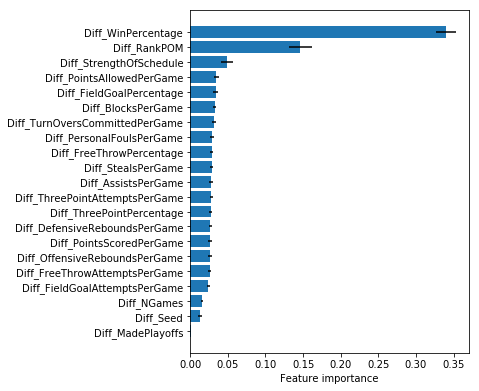

Elapsed time: 48.683 seconds
GradientBoostingRegressor
100 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 Accuracy: 0.748 +/- 0.011


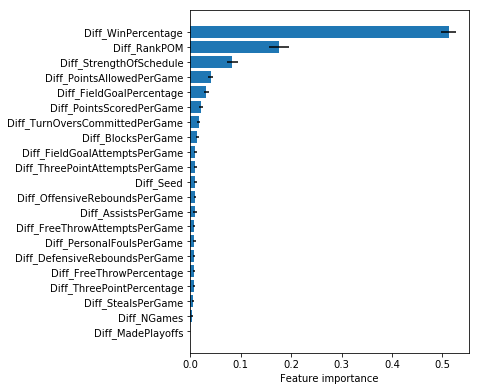

Elapsed time: 55.681 seconds


In [17]:
# Next, select other features by looking at feature importances
features = np.array([
    "Diff_RankPOM",
    "Diff_AssistsPerGame",
    "Diff_BlocksPerGame",
    "Diff_DefensiveReboundsPerGame", 
    "Diff_FieldGoalAttemptsPerGame",
    "Diff_FieldGoalPercentage",
    "Diff_FreeThrowAttemptsPerGame",
    "Diff_FreeThrowPercentage",
    "Diff_MadePlayoffs",
    "Diff_NGames",
    "Diff_OffensiveReboundsPerGame",
    "Diff_PersonalFoulsPerGame",
    "Diff_PointsAllowedPerGame",
    "Diff_PointsScoredPerGame",
    "Diff_Seed",
    "Diff_StealsPerGame",
    "Diff_StrengthOfSchedule",
    "Diff_ThreePointAttemptsPerGame",
    "Diff_ThreePointPercentage",
    "Diff_TurnOversCommittedPerGame",
    "Diff_WinPercentage"
])

X = df_total[features][::10]
y = df_total['Diff_Score'][::10]

# Look at two models
model_list = [RandomForestRegressor,GradientBoostingRegressor]

Nsamp = 100
for model in model_list:
    fitRegressorNTimes(
        model,
        X, y,
        Nsamp=Nsamp,
        features=features,
        plotimportance=True
    )

RandomForestRegressor
500 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 102 104 106 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250 252 254 256 258 260 262 264 266 268 270 272 274 276 278 280 282 284 286 288 290 292 294 296 298 300 302 304 306 308 310 312 314 316 318 320 322 324 326 328 330 332 334 336 338 340 342 344 346 348 350 352 354 356 358 360 362 364 366 368 370 372 374 376 378 380 382 384 386 388 390 392 394 396 398 400 402 404 406 408 410 412 414 416 418 420 422 424 426 428 430 432 434 436 438 440 442 444 446 448 450 452 454 456 458 460 462 464 466 468 470 472 474 476 478 480 482 484 486 488 490 492 494 496 498 Accuracy: 0.683

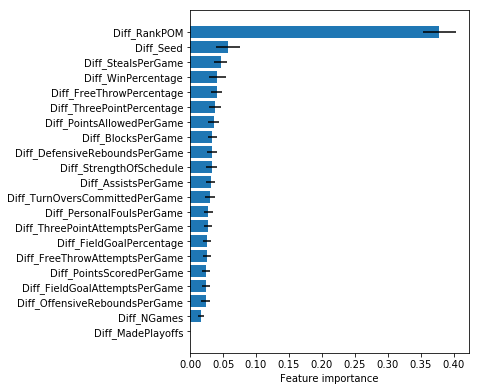

Elapsed time: 34.633 seconds
GradientBoostingRegressor
500 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 102 104 106 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250 252 254 256 258 260 262 264 266 268 270 272 274 276 278 280 282 284 286 288 290 292 294 296 298 300 302 304 306 308 310 312 314 316 318 320 322 324 326 328 330 332 334 336 338 340 342 344 346 348 350 352 354 356 358 360 362 364 366 368 370 372 374 376 378 380 382 384 386 388 390 392 394 396 398 400 402 404 406 408 410 412 414 416 418 420 422 424 426 428 430 432 434 436 438 440 442 444 446 448 450 452 454 456 458 460 462 464 466 468 470 472 474 476 478 480 482 484 486 488 49

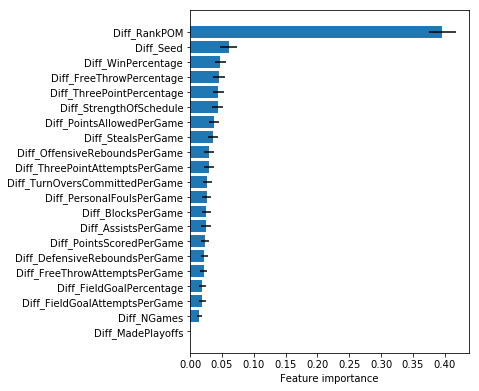

Elapsed time: 60.459 seconds


In [18]:
# Out of curiosity, do the same but with only tournament games
X = df_allseasons_tourney[features]
y = df_allseasons_tourney['Diff_Score']

model_list = [RandomForestRegressor,GradientBoostingRegressor]

Nsamp = 500
for model in model_list:
    fitRegressorNTimes(
        model,
        X, y,
        test_size=0.1,
        Nsamp=Nsamp,
        features=features,
        plotimportance=True
    )

# Test different models and different feature combos

Always keep rank, win percentage and strength of schedule. Try all 8 combinations of the next 3 best features.

In [19]:
# Just hard-code by hand since it's only 8
features_dict = {    
    1: np.array([
        'Diff_RankPOM', 'Diff_WinPercentage', 'Diff_StrengthOfSchedule',
    ]),
    2: np.array([
        'Diff_RankPOM', 'Diff_WinPercentage', 'Diff_StrengthOfSchedule',
        'Diff_PointsAllowedPerGame',
    ]),
    3: np.array([
        'Diff_RankPOM', 'Diff_WinPercentage', 'Diff_StrengthOfSchedule',
        'Diff_PointsScoredPerGame',
    ]),
    4: np.array([
        'Diff_RankPOM', 'Diff_WinPercentage', 'Diff_StrengthOfSchedule',
        'Diff_FieldGoalPercentage'
    ]),
    5: np.array([
        'Diff_RankPOM', 'Diff_WinPercentage', 'Diff_StrengthOfSchedule',
        'Diff_PointsAllowedPerGame', 'Diff_PointsScoredPerGame',
    ]),
    6: np.array([
        'Diff_RankPOM', 'Diff_WinPercentage', 'Diff_StrengthOfSchedule',
        'Diff_PointsAllowedPerGame', 'Diff_FieldGoalPercentage'
    ]),
    7: np.array([
        'Diff_RankPOM', 'Diff_WinPercentage', 'Diff_StrengthOfSchedule',
        'Diff_PointsScoredPerGame', 'Diff_FieldGoalPercentage'
    ]),
    8: np.array([
        'Diff_RankPOM', 'Diff_WinPercentage', 'Diff_StrengthOfSchedule',
        'Diff_PointsAllowedPerGame', 'Diff_PointsScoredPerGame', 'Diff_FieldGoalPercentage'
    ]),

}

In [20]:
model_dict = {
    'GaussianProcessRegressor': GaussianProcessRegressor,
    'LinearRegression': LinearRegression,
    'SVR': SVR,
    'KNeighborsRegressor': KNeighborsRegressor,
    'RandomForestRegressor': RandomForestRegressor
}

# Run the slower models fewer times
nsamp = {
    'GaussianProcessRegressor': 20,
    'LinearRegression': 100,
    'SVR': 50,
    'KNeighborsRegressor': 100,
    'RandomForestRegressor': 100
}

# Store all of the accuracies here
accuracies = {}
for key_feat, features in features_dict.items():
    print "Feature set %s:" % key_feat, features
    accuracies[key_feat] = {}
    # Only use 10% of the data for this step
    X = df_total[features].iloc[::10,:]
    y = df_total['Diff_Score'][::10]
    # Validate on tournament games only
    tourney_X = df_allseasons_tourney[features]
    tourney_y = df_allseasons_tourney['Diff_Score']
    for key_mod, model in model_dict.items():
        accuracies[key_feat][key_mod] = fitRegressorNTimes(
            model, X, y,
            val_Xy=[tourney_X, tourney_y],
            Nsamp=nsamp[key_mod], 
            returnall=True, 
            random_state=np.random.randint(1000), 
            plotimportance=False
        )

Feature set 1: ['Diff_RankPOM' 'Diff_WinPercentage' 'Diff_StrengthOfSchedule']
GaussianProcessRegressor
20 iterations...
0 2 4 6 8 10 12 14 16 18 Accuracy: 0.574 +/- 0.040
Elapsed time: 27.912 seconds
SVR
50 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 Accuracy: 0.694 +/- 0.033
Elapsed time: 16.130 seconds
KNeighborsRegressor
100 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 Accuracy: 0.694 +/- 0.039
Elapsed time: 0.877 seconds
LinearRegression
100 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 Accuracy: 0.702 +/- 0.035
Elapsed time: 0.690 seconds
RandomForestRegressor
100 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 

0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 Accuracy: 0.715 +/- 0.041
Elapsed time: 20.056 seconds
KNeighborsRegressor
100 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 Accuracy: 0.669 +/- 0.037
Elapsed time: 1.766 seconds
LinearRegression
100 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 Accuracy: 0.702 +/- 0.034
Elapsed time: 1.409 seconds
RandomForestRegressor
100 iterations...
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 Accuracy: 0.694 +/- 0.042
Elapsed time: 17.294 seconds
Feature set 8: ['Diff_RankPOM' 'Diff_WinPercentage' 'Diff_StrengthOfSchedule'
 'Diff_PointsAllowedPerGame' 'Diff_PointsScoredPerGame'
 'Diff_FieldGoalPercentage']
G

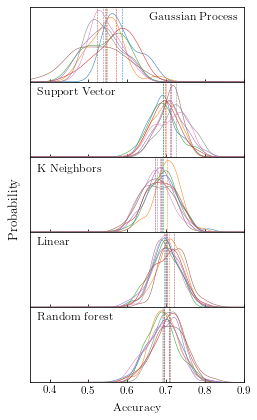

In [21]:
# Plot the distributions of accuracies
mpl.rcParams['text.usetex'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 11

texlabels = {
    'GaussianProcessRegressor': '${\\rm Gaussian~Process}$',
    'LinearRegression': '${\\rm Linear}$',
    'SVR': '${\\rm Support~Vector}$',
    'KNeighborsRegressor': '${\\rm K~Neighbors}$',
    'RandomForestRegressor': '${\\rm Random~forest}$',
}
label_position = {
    'GaussianProcessRegressor': 'right',
    'LinearRegression': 'left',
    'SVR': 'left',
    'KNeighborsRegressor': 'left',
    'RandomForestRegressor': 'left',
}
fig,ax = plt.subplots(len(model_dict.keys()),1,figsize=(3.5,6.0), sharex=True)
for i in range(len(model_dict.keys())):
    key_mod = model_dict.keys()[i]
    for key_feat in accuracies.keys():
        kernel = stats.gaussian_kde(accuracies[key_feat][key_mod])
        xs = np.linspace(0,1,500)
        line, = ax[i].plot(xs, kernel(xs), label="$%i$" % (key_feat), lw=0.5, )#label=texlabels[key_mod])
        ax[i].axvline(np.mean(accuracies[key_feat][key_mod]), ls='dashed', lw=0.5, color=line.get_color())
    ax[i].set_yticks([])
    if label_position[key_mod] == 'right':
        ax[i].text(0.97,0.95, texlabels[key_mod],va='top', ha='right', transform=ax[i].transAxes)
    else:
        ax[i].text(0.03,0.95, texlabels[key_mod],va='top', ha='left', transform=ax[i].transAxes)
    ax[i].set_ylim(0,ax[i].get_ylim()[1])
ax[0].set_xlim(0.35,0.9)
ax[-1].set_xlabel("${\\rm Accuracy}$")
plt.figtext(0.01,0.5,'${\\rm Probability}$', rotation=90, ha='left', va='center', fontsize=13)
plt.tight_layout(h_pad=0.0,rect=[0.05,0.0,1.0,1.0])
#plt.savefig('../figs/model_comparison.pdf')
plt.show()

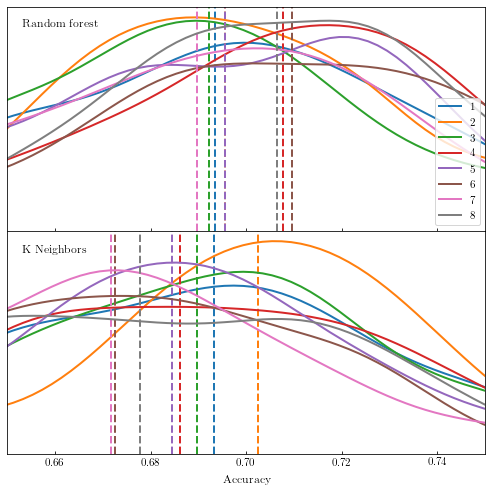

In [22]:
# Go with K neighbors or Random Forest. Zoom in to see the best feature set.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 11

key_mod_list = ['RandomForestRegressor','KNeighborsRegressor']
fig,ax = plt.subplots(len(key_mod_list),1,figsize=(7,3.5*len(key_mod_list)), sharex=True)
for i in range(len(key_mod_list)):
    key_mod = key_mod_list[i]
    for key_feat in accuracies.keys():
        kernel = stats.gaussian_kde(accuracies[key_feat][key_mod])
        xs = np.linspace(0,1,500)
        line, = ax[i].plot(xs, kernel(xs), label="$%i$" % (key_feat), lw=2)
        ax[i].axvline(np.mean(accuracies[key_feat][key_mod]), ls='dashed', lw=2, color=line.get_color())
    ax[i].text(0.03,0.95, texlabels[key_mod],va='top', ha='left', transform=ax[i].transAxes)
    ax[i].set_yticks([])
    ax[i].set_ylim(0,ax[i].get_ylim()[1])
ax[0].legend(loc='lower right')
ax[0].set_xlim(0.65,0.75)
ax[-1].set_xlabel("${\\rm Accuracy}$")
plt.tight_layout(h_pad=0.0)
#plt.savefig('../figs/model_comparison.pdf')
plt.show()

# Tournament simulations

In [23]:
def getGameMatchup(team1_id, team2_id, features, season):
    """
    Pulls the data from the team summaries dataframe and produces the game's feature vector
    
    :param team1_id: Unique TeamID for Team 1
    :type team1_id: int

    :param team2_id: Unique TeamID for Team 2
    :type team2_id: int

    :param features: Features to use
    :type features: list of strings

    :param season: Season for choosing the proper team summary
    :type season: int
    
    :return: Feature vector for the game
    :rtype: Numpy array (1D)
    """
    # Create empty DataFrame for the season and load in the regular season and tourney DataFrames
    df_season = df_reg_detailed[df_reg_detailed['Season'] == season]
    
    team_1_summary = df_team_summaries[season][df_team_summaries[season]['TeamID'] == team1_id]
    team_2_summary = df_team_summaries[season][df_team_summaries[season]['TeamID'] == team2_id]
    game = []
    for feat in features:
        game.append(team_1_summary.iloc[0][feat[5:]] - team_2_summary.iloc[0][feat[5:]])

    return np.array([game])

def simulateGame(teams, df_tourney_seeds, models=None, standardscalar=None, no_output=False):
    """
    Simulates a tournament game between two teams with seeds teams = ['seed1','seed2'].
    
    :param teams: Seed code (e.g., Y03) for the two team playing
    :type teams: list of 2 strings

    :param df_tourney_seeds: Tournament seeds DataFrame
    :type df_tourney_seeds: Pandas DataFrame

    :param models: Model for predicting winner. If None, will choose winner randomly. Defaults to None.
    :type models: List of sklearn models

    :param standardscalar: StandardScalar object fit to the training set data. Defaults to None.
    :type standardscalar: StandardScaler object

    :param no_output: Suppresses the printed output if True. Defaults to False.
    :type no_output: bool
    
    :return: Seed code (e.g., Y03) for the winning team
    :rtype: str
    """
    if models == None:
        # If no models, just choose one randomly
        return np.random.choice(teams)
    else:
        # Get the TeamIDs for the two teams
        team1_id = df_tourney_seeds[df_tourney_seeds["Seed"] == teams[0]]["TeamID"].values[0]
        team2_id = df_tourney_seeds[df_tourney_seeds["Seed"] == teams[1]]["TeamID"].values[0]
        
        # Initiate empty array and loop over the models
        predictions = np.zeros(len(models))
        for i in range(len(models)):
            # Get the game's feature vector and apply standardscalar
            game = getGameMatchup(team1_id, team2_id, features, season=2019)
            if standardscalar != None:
                game = standardscalar[i].transform(game)
            # Predict the score differential
            predictions[i] = models[i].predict(game)
        # Sum of signs of score differential. >0 team 1 wins, <0 team 2 wins
        prediction = np.sum(np.sign(predictions))
        if prediction > 0:
            if not no_output:
                percentchance = float(sum(predictions>0))/len(predictions)
                print "WINNER (%.1f%%): %s (%s) -- %s (%s) vs. %s (%s)" % (
                    percentchance*100.,
                    getTeamName(team1_id), teams[0],
                    getTeamName(team1_id), teams[0],
                    getTeamName(team2_id), teams[1]
                )
            return teams[0]
        else:
            # ****NOTE**** This gives the tie to team 2. Need to handle this case better
            if not no_output:
                percentchance = float(sum(predictions>0))/len(predictions)
                print "WINNER (%.1f%%): %s (%s) -- %s (%s) vs. %s (%s)" % (
                    (1.0 - percentchance)*100.,
                    getTeamName(team2_id), teams[1],
                    getTeamName(team1_id), teams[0],
                    getTeamName(team2_id), teams[1]
                )
            return teams[1]

def simulateRound(r, df_tourney_seeds, models=None, standardscalar=None, no_output=False):
    """
    Simulates a full round of the tournament, calling simulateGame
    
    :param r: List of matchups for the given round. Each matchup is a list with the two seed
        codes (e.g., Y03) of the teams playing.
    :type r: Numpy array, size = (n_games, 2)

    :param df_tourney_seeds: Tournament seeds DataFrame
    :type df_tourney_seeds: Pandas DataFrame

    :param models: Model for predicting winner. If None, will choose winner randomly. Defaults to None.
    :type models: List of sklearn models

    :param standardscalar: StandardScalar object fit to the training set data. Defaults to None.
    :type standardscalar: StandardScaler object
    
    :param no_output: Suppresses the printed output if True. Defaults to False.
    :type no_output: bool
    
    :return: List of matchups for the next round (based on the winners)
    :rtype: Numpy array, size = (n_games/2, 2)
    """
    r_next = []
    for i in range(0, len(r), 2):
        t1 = simulateGame(r[i], models=models, standardscalar=standardscalar, df_tourney_seeds=df_tourney_seeds, no_output=no_output)
        t2 = simulateGame(r[i+1], models=models, standardscalar=standardscalar, df_tourney_seeds=df_tourney_seeds, no_output=no_output)
        r_next.append([t1,t2])
    return np.array(r_next)

def simulateTourney(df_tourney_seeds, models=None, standardscalar=None, fix_playins=[], no_output=False):
    """
    Simulates the tournament using the given model(s)

    :param df_tourney_seeds: Tournament seeds DataFrame
    :type df_tourney_seeds: Pandas DataFrame

    :param models: Model for predicting winner. If None, will choose winner randomly. Defaults to None.
    :type models: List of sklearn models

    :param standardscalar: StandardScalar object fit to the training set data. Defaults to None.
    :type standardscalar: StandardScaler object
    
    :param fix_playins: List of seed codes (e.g., Y11b) of the play-in game winners. If empty, will predict
        the play-in game winners. Defaults to empty.
    :type fix_playins: List of strings
    
    :param no_output: Suppresses the printed output if True. Defaults to False.
    :type no_output: bool
    
    :return: List of the teams that make it to each round
    :rtype: List of Numpy arrays
    """
    # Play-in games
    playins = df_tourney_seeds[df_tourney_seeds['Seed'].str.len() == 4]
    playin_spots = playins.apply(lambda row: row['Seed'][:3], axis=1).unique()
    playin_games = {}
    for spot in playin_spots:
        if spot+'a' in fix_playins:
            playin_games[spot] = spot+'a'
        elif spot+'b' in fix_playins:
            playin_games[spot] = spot+'b'
        else:
            playin_games[spot] = simulateGame([spot+'a', spot+'b'], models=models, standardscalar=standardscalar, df_tourney_seeds=df_tourney_seeds, no_output=no_output)
    if not no_output:
        print "Play-in winners"
        print playin_games
    # Dictionary of matchups for each round
    rounds = {}
    # Set up round 1 first
    rounds[1] = []
    for division in ['W','X','Y','Z']:
        for i in range(8):
            rounds[1].append([division+str(i+1).zfill(2), division+str(16-i).zfill(2)])
    rounds[1] = np.array(rounds[1]).astype('|S4')
    for key,value in playin_games.items():
        rounds[1][np.where(rounds[1] == key)] = value
    
    # Loop over the rest of the rounds
    for i in range(2,7):
        if not no_output:
            print "\nSimulating round %i" % (i-1)
        rounds[i] = simulateRound(rounds[i-1], models=models, standardscalar=standardscalar, df_tourney_seeds=df_tourney_seeds, no_output=no_output)
        if i in [2,3]:
            rounds[i] = remap(rounds[i])

    # Play the championship game
    if not no_output:
        print "\nSimulating championship game"
    t1_id = df_tourney_seeds[df_tourney_seeds["Seed"] == rounds[6][0][0]]["TeamID"].values[0]
    t2_id = df_tourney_seeds[df_tourney_seeds["Seed"] == rounds[6][0][1]]["TeamID"].values[0]
    if not no_output:
        print "%s (%s) vs. %s (%s)" % (getTeamName(t1_id), rounds[6][0][0], getTeamName(t2_id), rounds[6][0][1])
    winner = simulateGame(rounds[6][0], models=models, standardscalar=standardscalar, df_tourney_seeds=df_tourney_seeds, no_output=no_output)
    winner_id = df_tourney_seeds[df_tourney_seeds["Seed"] == winner]["TeamID"].values[0]
    winner_name = getTeamName(winner_id)
    if not no_output:
        print "WINNER: %s (%s)" % (winner_name, winner)
    rounds[7] = [[winner]]
    return rounds

def printResults(result, df_tourney_seeds):
    for _round in range(1,8):
        print "================="
        print "Round %i" % _round
        print "================="
        for game in range(len(result[0][_round])):
            print "Game %i" % (game+1)
            possible_teams = {}
            for i in range(len(result)):
                for team in result[i][_round][game]:
                    if team in possible_teams.keys():
                        possible_teams[team] += 1
                    else:
                        possible_teams[team] = 1
            for team in possible_teams.keys():
                team_id = df_tourney_seeds[df_tourney_seeds["Seed"] == team]["TeamID"].values[0]
                team_name = getTeamName(team_id)
                print "%s: %0.1f%%" % (team_name, 100.*float(possible_teams[team])/float(len(result)))
            print ""
        print ""
        
def remap(games):
    """
    Helper function for building the bracket
    """
    new_games = []
    for j in range(4):
        all_teams = games[j*len(games)/4:(j+1)*len(games)/4].ravel()
        for i in range(len(all_teams)/2):
            t1 = all_teams[i]
            t2 = all_teams[-i-1]
            new_games.append([t1,t2])
    return np.array(new_games)

def manyModels(model, X, y, Nsamp=100, random_state=0, train_size=0.75):
    print "===================="
    print model.__name__
    print "===================="
    print "%i iterations..." % (Nsamp)
    
    np.random.seed(random_state)
    
    models, sc = [0]*Nsamp, [0]*Nsamp
    for i in range(Nsamp):
        print i
        seed1 = np.random.randint(1e9)
        seed2 = np.random.randint(1e9)

        # Use slightly different data each time
        train_X, _, train_y, _ = train_test_split(X, y, test_size=1.0-train_size, random_state=seed1)
        sc[i] = StandardScaler()
        train_X = sc[i].fit_transform(train_X)
    
        try:
            models[i] = model(random_state=seed2)
        except:
            models[i] = model()
        
        models[i].fit(train_X, train_y)
    return models, sc

In [27]:
# Use Random Forest Regressor. Only use 10% of the data per training (train_size=0.1)
features = features_dict[4]

X = df_allseasons_reg[features]
y = df_allseasons_reg["Diff_Score"]

Nsamp=250
models, standard_scalar = manyModels(RandomForestRegressor, X, y, Nsamp=Nsamp, train_size=0.1, random_state=0)

RandomForestRegressor
250 iterations...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [28]:
# Fix the play-in games and predict the final bracket
# W12a - Indiana, Y16b - TX Southern, Z16b - Wright State, X11b - Rutgers vs Xlla - Notre Dame
fix_playins = ['W12a','X11a','Y16b','Z16b']

df_tourney_seeds = df_seeds[df_seeds['Season'] == 2022]
result = simulateTourney(
    df_seeds[df_seeds['Season'] == 2022],
    models = models,
    standardscalar = standard_scalar,
    fix_playins = fix_playins,
    no_output=False
)

Play-in winners
{'Z16': 'Z16b', 'X11': 'X11a', 'Y16': 'Y16b', 'W12': 'W12a'}

Simulating round 1
WINNER (100.0%): Baylor (W01) -- Baylor (W01) vs. Norfolk St (W16)
WINNER (100.0%): Kentucky (W02) -- Kentucky (W02) vs. St Peter's (W15)
WINNER (97.6%): Purdue (W03) -- Purdue (W03) vs. Yale (W14)
WINNER (55.6%): Akron (W13) -- UCLA (W04) vs. Akron (W13)
WINNER (56.0%): St Mary's CA (W05) -- St Mary's CA (W05) vs. Indiana (W12a)
WINNER (87.2%): Virginia Tech (W11) -- Texas (W06) vs. Virginia Tech (W11)
WINNER (63.2%): Murray St (W07) -- Murray St (W07) vs. San Francisco (W10)
WINNER (78.0%): North Carolina (W08) -- North Carolina (W08) vs. Marquette (W09)
WINNER (99.6%): Gonzaga (X01) -- Gonzaga (X01) vs. Georgia St (X16)
WINNER (100.0%): Duke (X02) -- Duke (X02) vs. CS Fullerton (X15)
WINNER (100.0%): Texas Tech (X03) -- Texas Tech (X03) vs. Montana St (X14)
WINNER (88.8%): Arkansas (X04) -- Arkansas (X04) vs. Vermont (X13)
WINNER (96.0%): New Mexico St (X12) -- Connecticut (X05) vs. New 